In [1]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

sys.path.append('../MCEq')
os.chdir('..')

#import solver related modules
#import primary model choices
import crflux.models as pm

from MCEq.core import MCEqRun
#from MCEq import config
import MCEq.config as config
from MCEq.particlemanager import MCEqParticle

In [ ]:
''' This changes the path MCEq takes to get its decay and particle tables,
# The below options are for the new file sent by Anatoli for SIBYLL2.3d 
# and the updated decays for things like tau
# if you just want the basic MCEq, do not run this cell or the one following MCEqRun
# To use the old MCEq, change branch back to main branch and not new_build_model'''
config.mceq_db_fname = "mceq_db_fine_v150.h5"
config.decay_db_name = "full_decays" #or "pythia_decays_K3b_202206"
config.muon_helicity_dependence = True

In [12]:
mceq_run = MCEqRun(
interaction_medium = 'air',
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.HillasGaisser2012, 'H3a'),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=84.25,
#expand the rest of the options from mceq_config.py
#**config
)
mceq_run.set_density_model(('MSIS00_IC', ('SouthPole', "October")))
mag = 3
pman = mceq_run.pman

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'October')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 84.25


In [ ]:
'''Also do not run this cell for the old MCEq'''                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# Re-apply the appropriate databases, hopefully initializes the tables for our added particles
pman.set_cross_sections_db(mceq_run._int_cs)
pman.set_decay_channels(mceq_run._decays)
pman.set_interaction_model(mceq_run._int_cs, mceq_run._interactions)

In [4]:
#What file you want to pull from/save to
run = 2

In [16]:
import numpy as np, gzip, pickle, sys, os
from pathlib import Path

# make the zenith grid and select 3 angles
cos_grid   = np.linspace(np.cos(np.deg2rad(90)), np.cos(np.deg2rad(0)), 21)
wanted_cos = (0.1, 0.5, 0.9)
tol        = 1e-6 #tolerance for selecting angles you want with angles MCEq actually used

# initialize containers & dictionaries
tot_mu, tot_numu, tot_nue, tot_nutau         = [], [], [], []
conv_mu, conv_numu, conv_nue, conv_nutau     = [], [], [], []

data = {
    "avg": {k: None for k in (
        "mu","numu","nue","nutau",
        "mu_conv","numu_conv","nue_conv","nutau_conv")},
}
for c in wanted_cos:
    data[c] = {k: None for k in (
        "mu","numu","nue","nutau",
        "mu_conv","numu_conv","nue_conv","nutau_conv")}

# main loop that solves and fetches the data from mceq_run and stores it
for cosv in cos_grid:
    theta_deg = float(np.degrees(np.arccos(cosv)))
    mceq_run.set_theta_deg(theta_deg)
    mceq_run.solve()

    mu_t    = mceq_run.get_solution("total_mu+",   mag) + mceq_run.get_solution("total_mu-",   mag)
    numu_t  = mceq_run.get_solution("total_numu",  mag) + mceq_run.get_solution("total_antinumu",mag)
    nue_t   = mceq_run.get_solution("total_nue",   mag) + mceq_run.get_solution("total_antinue", mag)
    nutau_t = mceq_run.get_solution("total_nutau", mag) + mceq_run.get_solution("total_antinutau",mag)

    mu_c    = mceq_run.get_solution("conv_mu+",   mag) + mceq_run.get_solution("conv_mu-",   mag)
    numu_c  = mceq_run.get_solution("conv_numu",  mag) + mceq_run.get_solution("conv_antinumu",mag)
    nue_c   = mceq_run.get_solution("conv_nue",   mag) + mceq_run.get_solution("conv_antinue", mag)
    nutau_c = mceq_run.get_solution("conv_nutau", mag) + mceq_run.get_solution("conv_antinutau",mag)

    tot_mu.append(mu_t);       conv_mu.append(mu_c)
    tot_numu.append(numu_t);   conv_numu.append(numu_c)
    tot_nue.append(nue_t);     conv_nue.append(nue_c)
    tot_nutau.append(nutau_t); conv_nutau.append(nutau_c)

    for tgt in wanted_cos:
        if abs(cosv - tgt) < tol:
            d = data[tgt]
            d["mu"],       d["mu_conv"]       = mu_t,    mu_c
            d["numu"],     d["numu_conv"]     = numu_t,  numu_c
            d["nue"],      d["nue_conv"]      = nue_t,   nue_c
            d["nutau"],    d["nutau_conv"]    = nutau_t, nutau_c
            break

# take the averages for all particles (w/ & w/o prompt)
data["avg"]["mu"]        = np.mean(tot_mu,    axis=0)
data["avg"]["numu"]      = np.mean(tot_numu,  axis=0)
data["avg"]["nue"]       = np.mean(tot_nue,   axis=0)
data["avg"]["nutau"]     = np.mean(tot_nutau, axis=0)
data["avg"]["mu_conv"]   = np.mean(conv_mu,    axis=0)
data["avg"]["numu_conv"] = np.mean(conv_numu,  axis=0)
data["avg"]["nue_conv"]  = np.mean(conv_nue,   axis=0)
data["avg"]["nutau_conv"]= np.mean(conv_nutau, axis=0)

# calculate ratios and store
for c in wanted_cos:
    for fl in ("mu","numu","nue","nutau"):
        data[c][f"{fl}_ratio"]       = data[c][fl]            / data["avg"][fl]
        data[c][f"{fl}_conv_ratio"]  = data[c][f"{fl}_conv"]  / data["avg"][f"{fl}_conv"]

# save energy grid in storable object
data["energy"] = mceq_run.e_grid

# save the data object to FishPlot_data{run}.pkl.gz for later :)
outfile = Path(f"FishPlot_data{run}.pkl.gz")
with gzip.open(outfile, "wb") as fh:
    pickle.dump(data, fh, protocol=pickle.HIGHEST_PROTOCOL)

print(f"[OK] Saved fish‑plot data → {outfile.resolve()}")

MSIS00IceCubeCentered::set_theta(): latitude = -89.86 for zenith angle = 90.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 87.13


KeyboardInterrupt: 

In [ ]:
astro_flux = compute_theory_flux("astro 9.5yrs", filedata["energy"], ["mu","numu","nue","nutau","mu_conv","numu_conv","nue_conv","nutau_conv"], filedata, 0.1)

({'mu': array([2.69717876e-06, 2.73791490e-06, 3.08216731e-06, 4.04802100e-06,
         6.30094937e-06, 1.12053102e-05, 2.14946023e-05, 4.24343608e-05,
         8.40451650e-05, 1.64429448e-04, 3.15047344e-04, 5.87500265e-04,
         1.06267898e-03, 1.85725843e-03, 3.13313686e-03, 5.08879703e-03,
         7.95022591e-03, 1.19402559e-02, 1.73186274e-02, 2.44649136e-02,
         3.37703773e-02, 4.51384787e-02, 5.82356106e-02, 7.35001710e-02,
         9.00600387e-02, 1.07804651e-01, 1.26223284e-01, 1.44978509e-01,
         1.63591862e-01, 1.81433025e-01, 1.97908425e-01, 2.12486074e-01,
         2.24155035e-01, 2.32696044e-01, 2.38281943e-01, 2.40846771e-01,
         2.40542684e-01, 2.37349712e-01, 2.31395485e-01, 2.23001622e-01,
         2.12553417e-01, 2.00487273e-01, 1.87126702e-01, 1.72969682e-01,
         1.58437093e-01, 1.43988131e-01, 1.29782695e-01, 1.16048331e-01,
         1.03029281e-01, 9.08401556e-02, 7.96262856e-02, 6.93420651e-02,
         6.00417264e-02, 5.17183637e-02, 4.42

In [9]:
# Build the zenith grid
cos_spaced = np.linspace(
    np.cos(np.deg2rad(90.)),
    np.cos(np.deg2rad(0.)),
    21,
)
cos_spaced

array([6.123234e-17, 5.000000e-02, 1.000000e-01, 1.500000e-01,
       2.000000e-01, 2.500000e-01, 3.000000e-01, 3.500000e-01,
       4.000000e-01, 4.500000e-01, 5.000000e-01, 5.500000e-01,
       6.000000e-01, 6.500000e-01, 7.000000e-01, 7.500000e-01,
       8.000000e-01, 8.500000e-01, 9.000000e-01, 9.500000e-01,
       1.000000e+00])

In [5]:
#Load in data from FishPlot data file saved in MCEqDatafiles
import gzip, pickle
import numpy as np
path = f"/net/apphome/home/nbenton/MCEqProject/MCEqDatafiles/FishPlot_data{run}.pkl.gz"
with gzip.open(path, "rb") as fh:
    filedata = pickle.load(fh)

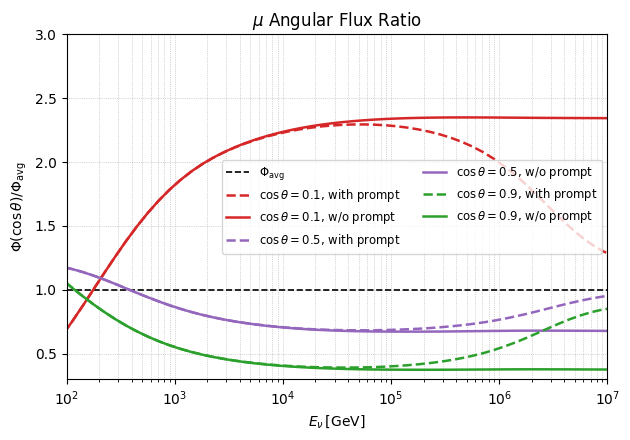

In [7]:
# choose the flavour you want to plot
particle = "mu"        # "mu", "numu", "nue" or "nutau"


COS_VALS  = (0.1, 0.5, 0.9) # These are thre three angles we select to compare
COLORS    = {0.1: "tab:red", 0.5: "tab:purple", 0.9: "tab:green"}
LATEX_SYM = dict(mu=r"\mu",
                 numu=r"\nu_{\mu}",
                 nue=r"\nu_{e}",
                 nutau=r"\nu_{\tau}")
sym = LATEX_SYM[particle]

energy = filedata["energy"]      # load in the 1-D array energy bins (x-axis)

fig, ax = plt.subplots(figsize=(6.4, 4.5))

# add center line for average flux
ax.axhline(1.0, color="black", ls="--", lw=1.2, label=r"$\Phi_{\mathrm{avg}}$")

# plot both w/ & w/o prompt for each of the three angles
for cosv in COS_VALS:
    col = COLORS[cosv]

    # with prompt (total / average‑total) — dashed
    ax.plot(energy,
            filedata[cosv][f"{particle}_ratio"],
            color=col, lw=1.8, ls="--",
            label=rf"$\cos\theta={cosv:.1f}$, with prompt")

    # without prompt (conventional / average‑conventional) — solid
    ax.plot(energy,
            filedata[cosv][f"{particle}_conv_ratio"],
            color=col, lw=1.8, ls="-",
            label=rf"$\cos\theta={cosv:.1f}$, w/o prompt")

ax.set_xscale("log")
ax.set_xlim(1e2, 1e7)
ax.set_ylim(0.3, 3.0)

ax.set_xlabel(r"$E_{\nu}\,[\mathrm{GeV}]$")
ax.set_ylabel(r"$\Phi(\cos\theta)/\Phi_{\mathrm{avg}}$")
ax.set_title(fr"${sym}$ Angular Flux Ratio")

ax.legend(fontsize="small", ncol=2, frameon=True)
ax.grid(True, which="both", ls=":", lw=0.5)
plt.tight_layout()
plt.show()

In [9]:
# Define models with their parameters
models = {"astro 9.5yrs":     {"phi": 1.44, "phi_u": 0.25, "phi_l": -0.26, "gamma": 2.37, "gamma_u": 0.09, "gamma_l": -0.09, "alpha":   1, "Emin": 15e3, "Emax":   5e6}, # at https://arxiv.org/abs/2111.10299
          "cscd 2yrs":        {"phi":  2.3, "phi_u":  0.7, "phi_l":  -0.6, "gamma": 2.67, "gamma_u": 0.12, "gamma_l": -0.13, "alpha":   1, "Emin": 10e3, "Emax":   1e7}, # at https://pos.sissa.it/236/1109/pdf       # cscd hans
          "cscd 6yrs":        {"phi": 1.66, "phi_u": 0.25, "phi_l": -0.27, "gamma": 2.53, "gamma_u": 0.07, "gamma_l": -0.07, "alpha":   1, "Emin": 16e3, "Emax": 2.6e6}, # at https://arxiv.org/abs/2001.09520
          "cscd 11yrs":       {"phi": 1.83, "phi_u": 0.21, "phi_l": -0.21, "gamma": 2.58, "gamma_u": 0.06, "gamma_l": -0.06, "alpha":   1, "Emin": 16e3, "Emax": 2.6e6}, # at https://arxiv.org/abs/2507.08421
          "starting tracks":  {"phi": 1.68, "phi_u": 0.19, "phi_l": -0.22, "gamma": 2.58, "gamma_u": 0.10, "gamma_l": -0.10, "alpha":   1, "Emin":  3e3, "Emax": 550e3}, # at https://arxiv.org/abs/2402.18026
          "hese 4yrs 10TeV":  {"phi":  8.6, "phi_u":  2.4, "phi_l":  -2.4, "gamma": 2.87, "gamma_u": 0.18, "gamma_l": -0.18, "alpha": 1/3, "Emin": 10e3, "Emax":   1e7}, # at https://arxiv.org/abs/1605.01556
          "hese 4yrs 60TeV":  {"phi":  6.5, "phi_u":  3.2, "phi_l":  -2.5, "gamma": 2.72, "gamma_u": 0.30, "gamma_l": -0.29, "alpha": 1/3, "Emin": 60e3, "Emax":   1e7}, # at https://arxiv.org/abs/1605.01556
          "hese 6yrs":        {"phi": 2.46, "phi_u":  0.8, "phi_l":  -0.8, "gamma": 2.92, "gamma_u": 0.33, "gamma_l": -0.29, "alpha":   1, "Emin": 60e3, "Emax":   1e7}, # at https://pos.sissa.it/301/981/pdf
          "hese 7.5yrs":      {"phi": 6.37, "phi_u": 1.46, "phi_l": -1.63, "gamma": 2.87, "gamma_u": 0.16, "gamma_l": -0.19, "alpha": 1/3, "Emin": 60e3, "Emax":   1e7}, # at https://arxiv.org/abs/2011.03545
          "aachen 8yrs":      {"phi": 1.01, "phi_u": 0.26, "phi_l": -0.23, "gamma": 2.19, "gamma_u": 0.10, "gamma_l": -0.10, "alpha":   1, "Emin":119e3, "Emax": 4.8e6}, # at https://pos.sissa.it/301/1005/pdf
          "aachen 9.5yrs":    {"phi": 1.44, "phi_u": 0.25, "phi_l": -0.24, "gamma": 2.28, "gamma_u": 0.08, "gamma_l": -0.09, "alpha":   1, "Emin": 40e3, "Emax": 3.5e6}, # at https://pos.sissa.it/358/1017/pdf
          "global fit 2yrs":  {"phi": 2.06, "phi_u":  0.4, "phi_l":  -0.3, "gamma": 2.46, "gamma_u": 0.12, "gamma_l": -0.12, "alpha":   1, "Emin": 25e3, "Emax": 1.4e6}, # at https://arxiv.org/abs/1410.1749
          "global fit 10yrs": {"phi": 1.80, "phi_u": 0.13, "phi_l": -0.16, "gamma": 2.52, "gamma_u": 0.04, "gamma_l": -0.04, "alpha":   1, "Emin":2.5e3, "Emax": 6.3e6}} # at https://arxiv.org/pdf/2308.00191

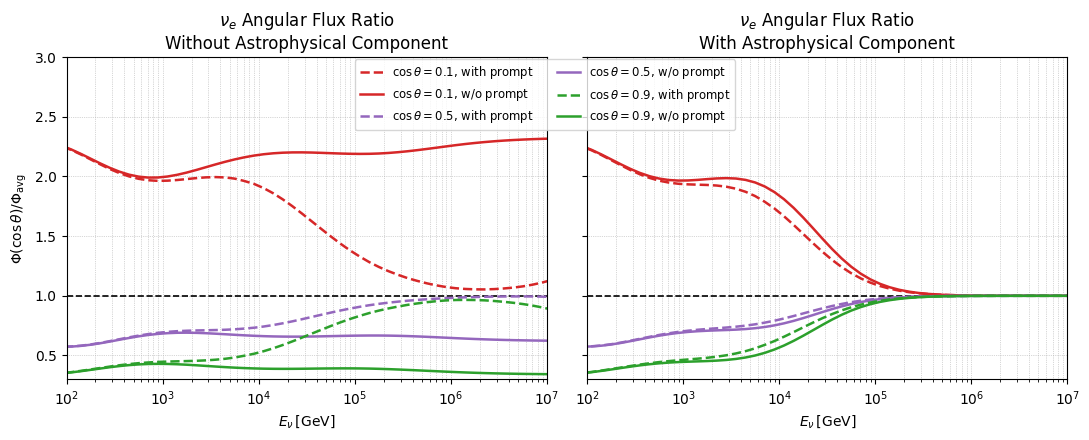

In [11]:
# ------------------------------------------------------------------
# 1)  CONFIG – choose flavour and astro model
# ------------------------------------------------------------------
particle      = "nue"               # "mu", "numu", "nue", "nutau"
astro_model   = "astro 9.5yrs"      # key in your `models` dict
energy        = filedata["energy"]  # 1-D bin centres (GeV)

COS_VALS  = (0.1, 0.5, 0.9)
COLORS    = {0.1: "tab:red", 0.5: "tab:purple", 0.9: "tab:green"}
LATEX_SYM = dict(mu=r"\mu", numu=r"\nu_{\mu}", nue=r"\nu_{e}", nutau=r"\nu_{\tau}")
sym       = LATEX_SYM[particle]


# 2)  QUICK helper – astrophysical Φ(E) (in GeV-weighted units)

def astro_component(E, model_name=astro_model):
    """
    Return E²·Φ_astro(E) for the selected model (GeV cm⁻² s⁻¹ sr⁻¹).
    ‘models’ must exist in the workspace.
    """
    m   = models[model_name]          # alpha, phi, gamma stored here
    E0  = 1e5                         # 100 TeV reference
    return m["alpha"] * m["phi"] * 1e-18 * (E / E0) ** (-m["gamma"]) * E**3


A_E2 = astro_component(energy)        # same for every zenith bin

# ------------------------------------------------------------------
# 3)  BUILD two dicts for plotting
# ------------------------------------------------------------------
noAstro   = {}      # keep your original ratios (already in filedata)
withAstro = {}      # new ratios including the extra component

for cosv in COS_VALS:
    # ----- without prompt (conventional)
    conv          = filedata[cosv][f"{particle}_conv"]
    conv_avg      = filedata["avg"][f"{particle}_conv"]
    noAstro[(cosv, "conv")] = filedata[cosv][f"{particle}_conv_ratio"]

    conv_A        = conv + A_E2
    conv_avg_A    = conv_avg + A_E2
    withAstro[(cosv, "conv")] = conv_A / conv_avg_A

    # ----- with prompt (total)
    tot           = filedata[cosv][particle]
    tot_avg       = filedata["avg"][particle]
    noAstro[(cosv, "tot")]  = filedata[cosv][f"{particle}_ratio"]

    tot_A         = tot + A_E2
    tot_avg_A     = tot_avg + A_E2
    withAstro[(cosv, "tot")] = tot_A / tot_avg_A

# ------------------------------------------------------------------
# 4)  PLOT: side-by-side panels
# ------------------------------------------------------------------
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True)

def draw(ax, ratios, title):
    ax.axhline(1.0, color="black", ls="--", lw=1.2)   # baseline
    for cosv in COS_VALS:
        col = COLORS[cosv]
        ax.plot(energy, ratios[(cosv, "tot")],  ls="--", lw=1.8, color=col,
                label=rf"$\cos\theta={cosv:.1f}$, with prompt")
        ax.plot(energy, ratios[(cosv, "conv")], ls="-",  lw=1.8, color=col,
                label=rf"$\cos\theta={cosv:.1f}$, w/o prompt")
    ax.set_xscale("log");  ax.set_xlim(1e2, 1e7)
    ax.set_ylim(0.3, 3.0)
    ax.set_xlabel(r"$E_{\nu}\,[\mathrm{GeV}]$")
    ax.set_title(title)
    ax.grid(True, which="both", ls=":", lw=0.5)

# left = original
draw(ax0, noAstro, fr"${sym}$ Angular Flux Ratio" "\nWithout Astrophysical Component")
ax0.set_ylabel(r"$\Phi(\cos\theta)/\Phi_{\mathrm{avg}}$")

# right = atmospheric + astrophysical
draw(ax1, withAstro, fr"${sym}$ Angular Flux Ratio" "\nWith Astrophysical Component")

# one shared legend (upper centre)
handles, labels = ax0.get_legend_handles_labels()
fig.legend(handles, labels,
           ncol=2, fontsize="small",
           loc="upper center",
           bbox_to_anchor=(0.5, 0.87)) 
fig.tight_layout()
plt.show()